In [1]:
suppressPackageStartupMessages(library(SingleCellExperiment))
suppressPackageStartupMessages(library(scater))
suppressPackageStartupMessages(library(scran))
suppressPackageStartupMessages(library(argparse))
suppressPackageStartupMessages(library(Seurat))

here::i_am("processing/1_create_seurat_rna.R")
source(here::here("settings.R"))
source(here::here("utils.R"))

here() starts at /rds/project/rds-SDzz0CATGms/users/bt392/03_Stat3_RNA/code



In [74]:
args = list()
args$samples <- opts$samples
args$sce <- io$rna.sce
#args$metadata <- io$metadata
args$metadata <- paste0(io$basedir,"/results/rna/mapping/sample_metadata_after_mapping.txt.gz")
args$pca = '/rds/project/rds-SDzz0CATGms/users/bt392/03_Stat3_RNA/results/rna/dimensionality_reduction/sce/pca_features2500_pcs40.txt.gz'
# args$features <- 1000
# args$npcs <- 30
# args$test <- FALSE
# args$colour_by <- c("celltype.mapped","sample")
# args$vars.to.regress <- c("nFeature_RNA","mitochondrial_percent_RNA")
# args$batch.correction <- c("sample")
# args$remove_ExE_cells <- FALSE
# args$outdir <- paste0(io$basedir,"/results/rna/dimensionality_reduction/test")

In [75]:
##########################
## Load sample metadata ##
##########################

sample_metadata <- fread(args$metadata) %>%
   .[pass_rnaQC==TRUE & doublet_call==FALSE & sample%in%args$samples]

In [76]:
summary(duplicated(sample_metadata$cell))

   Mode   FALSE 
logical   38437 

In [77]:
head(sample_metadata)

cell                                          sample                    
1 SLX-21143_SITTA2_HTJH3DSX2#AAACCCAAGATGTTCC-1 SLX-21143_SITTA2_HTJH3DSX2
2 SLX-21143_SITTA2_HTJH3DSX2#AAACCCATCAGACCTA-1 SLX-21143_SITTA2_HTJH3DSX2
3 SLX-21143_SITTA2_HTJH3DSX2#AAACGAACAATGTTGC-1 SLX-21143_SITTA2_HTJH3DSX2
4 SLX-21143_SITTA2_HTJH3DSX2#AAACGAACACACCAGC-1 SLX-21143_SITTA2_HTJH3DSX2
5 SLX-21143_SITTA2_HTJH3DSX2#AAACGAAGTGATAGTA-1 SLX-21143_SITTA2_HTJH3DSX2
6 SLX-21143_SITTA2_HTJH3DSX2#AAACGAAGTTAAGACA-1 SLX-21143_SITTA2_HTJH3DSX2
  barcode            nFeature_RNA nCount_RNA mitochondrial_percent_RNA
1 AAACCCAAGATGTTCC-1 4837         53199      1.47                     
2 AAACCCATCAGACCTA-1 4973         24165      0.95                     
3 AAACGAACAATGTTGC-1 5585         34341      0.22                     
4 AAACGAACACACCAGC-1 5016         41496      1.66                     
5 AAACGAAGTGATAGTA-1 4308         44249      0.60                     
6 AAACGAAGTTAAGACA-1 3826         17237      1.42                     
  ribosomal_percent_RNA stage tdTom idx tdTom_corr pass_rnaQC doublet_score
1 22.87                 E8.5  TRUE  1   TRUE       TRUE       0.14         
2 19.26                 E8.5  TRUE  3   TRUE       TRUE       0.31         
3 26.76                 E8.5  TRUE  5   TRUE       TRUE       0.28         
4 25.01                 E8.5  TRUE  6   TRUE       TRUE       0.16         
5 24.26                 E8.5  TRUE  7   TRUE       TRUE       0.11         
6 28.43                 E8.5  TRUE  8   TRUE       TRUE       0.13         
  doublet_call celltype.mapped_mnn           celltype.score_mnn
1 FALSE        Erythroid                     1.00              
2 FALSE        Mesenchyme                    1.00              
3 FALSE        Anterior somitic tissues      0.96              
4 FALSE        Erythroid                     1.00              
5 FALSE        Erythroid                     1.00              
6 FALSE        Ventral hindbrain progenitors 0.28              
  stage.mapped_mnn cellstage.score_mnn closest.cell_mnn
1 E9.25            1.00                ext_cell_262426 
2 E8.75            0.60                ext_cell_141053 
3 E8.75            0.32                ext_cell_144992 
4 E8.5             0.92                ext_cell_279020 
5 E9.5             0.52                ext_cell_278890 
6 E9.25            0.68                ext_cell_212088

In [78]:
pca = fread(args$pca) %>% 
    .[match(sample_metadata$cell, cell),] %>% 
    as.data.frame() %>% 
    tibble::column_to_rownames('cell') %>% 
    as.matrix()

In [79]:
counts = matrix(ncol=nrow(pca), nrow=1)
colnames(counts) = rownames(pca)
rownames(counts) = 'x'

In [81]:
seurat = CreateSeuratObject(counts)

In [82]:
seurat

An object of class Seurat 
1 features across 38437 samples within 1 assay 
Active assay: RNA (1 features, 0 variable features)

In [83]:
seurat[["pca"]] <- CreateDimReducObject(embeddings = pca, key = "PC_", assay = DefaultAssay(seurat))


In [84]:
umap = fread('/rds/project/rds-SDzz0CATGms/users/bt392/03_Stat3_RNA/results/rna/dimensionality_reduction/sce/umap_features2500_pcs40_neigh30_dist0.3.txt.gz') %>% 
    as.data.frame() %>% 
    tibble::column_to_rownames('cell') %>% 
    as.matrix()
seurat[["umap"]] <- CreateDimReducObject(embeddings = umap, key = "UMAP_", assay = DefaultAssay(seurat))


In [85]:
seurat <- FindNeighbors(seurat, dims = 1:40)
seurat <- FindClusters(seurat, resolution = 0.5)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 38437
Number of edges: 1383159

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9400
Number of communities: 24
Elapsed time: 5 seconds


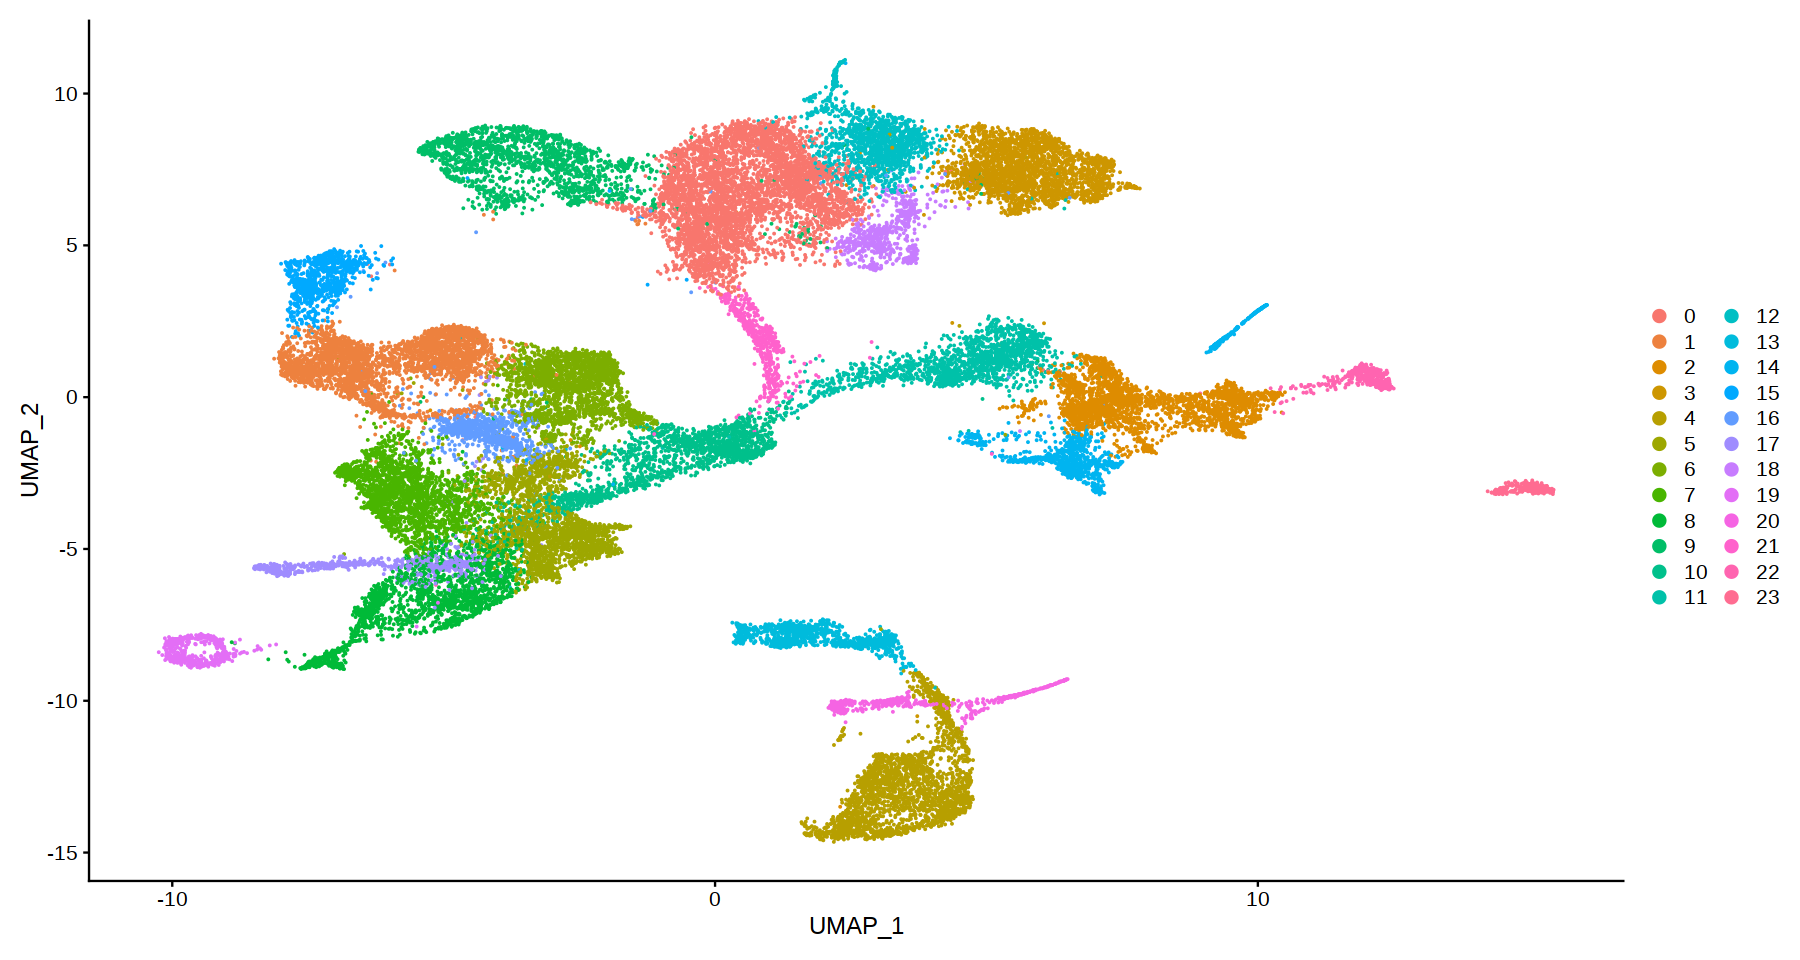

In [86]:
DimPlot(seurat, reduction = "umap")

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 38437
Number of edges: 1383159

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8175
Number of communities: 73
Elapsed time: 7 seconds


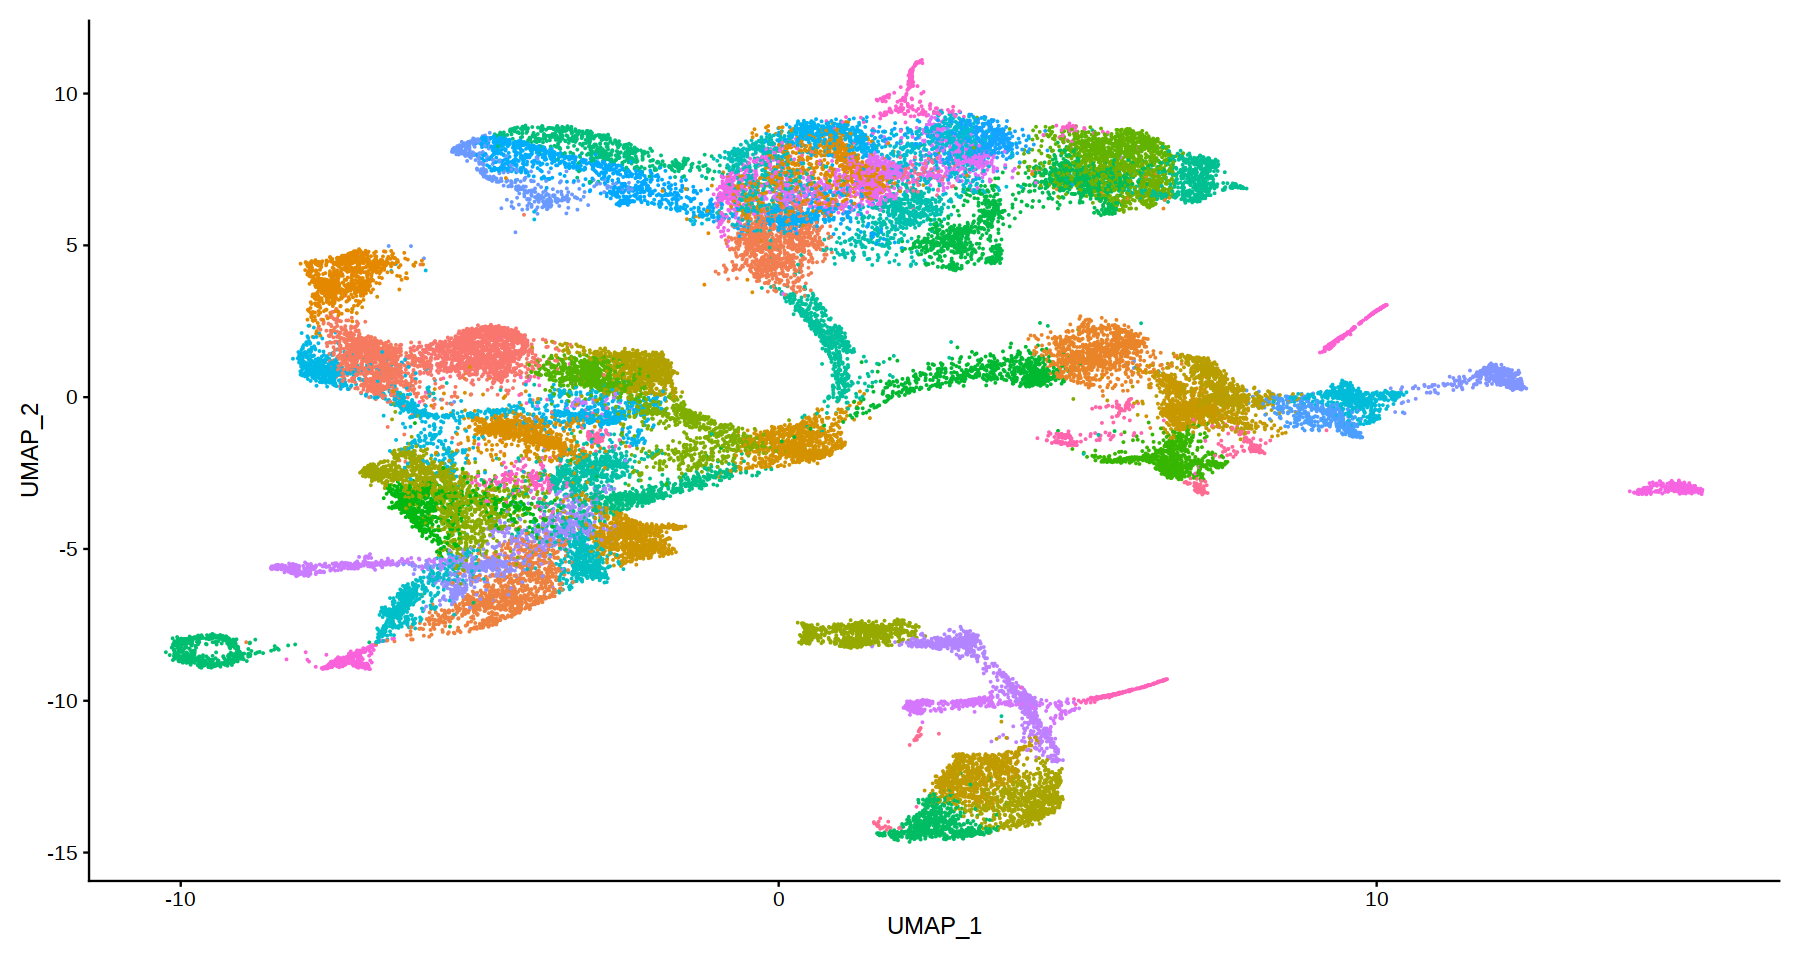

In [163]:
seurat <- FindClusters(seurat, resolution = 5) # , algorithm = 4
DimPlot(seurat, reduction = "umap") + theme(legend.position = 'none')

In [117]:
summary(sample_metadata$cell == rownames(seurat@meta.data))

   Mode    TRUE 
logical   38437 

In [118]:
sample_metadata = sample_metadata[match(rownames(seurat@meta.data), cell)]
summary(sample_metadata$cell == rownames(seurat@meta.data))

   Mode    TRUE 
logical   38437 

In [164]:
seurat@meta.data$celltype = sample_metadata$celltype.mapped_mnn

In [165]:
test = as.data.table(seurat@meta.data) %>%
    .[,clust_tot := .N, by='seurat_clusters'] %>%
    .[,celltype_clust := .N, by=c('celltype','seurat_clusters')] %>%
    unique(by=c('celltype','seurat_clusters')) %>%
    .[,proportion := round(celltype_clust/clust_tot*100, 2)] %>%
    .[order(-proportion)] %>% 
    unique(by='seurat_clusters') %>% 
  #  .[,celltype_annot := ifelse(proportion > 35, celltype, 'unknown')] 
    .[,celltype_annot := celltype] 

seurat@meta.data$celltype_annot = test[match(seurat@meta.data$seurat_clusters, seurat_clusters),celltype_annot]

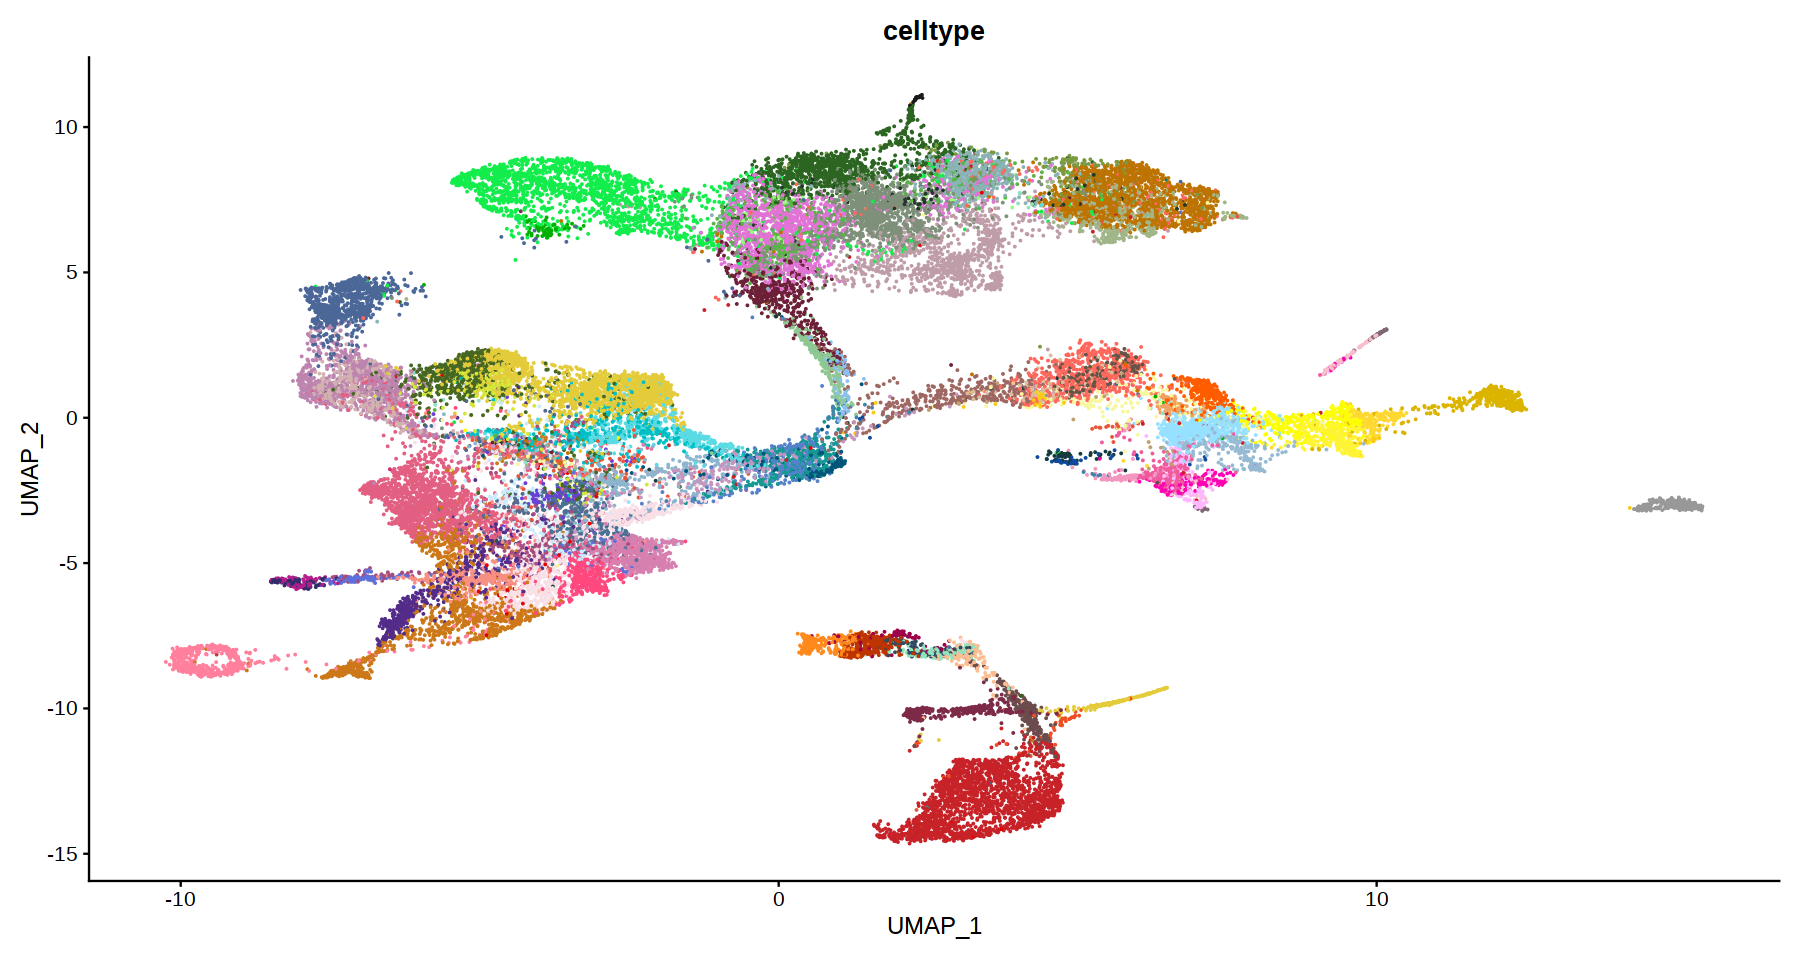

In [166]:
DimPlot(seurat, reduction = "umap", group.by='celltype') + 
    scale_color_manual(values = opts$celltype.colors) + 
    theme(legend.position = 'none')

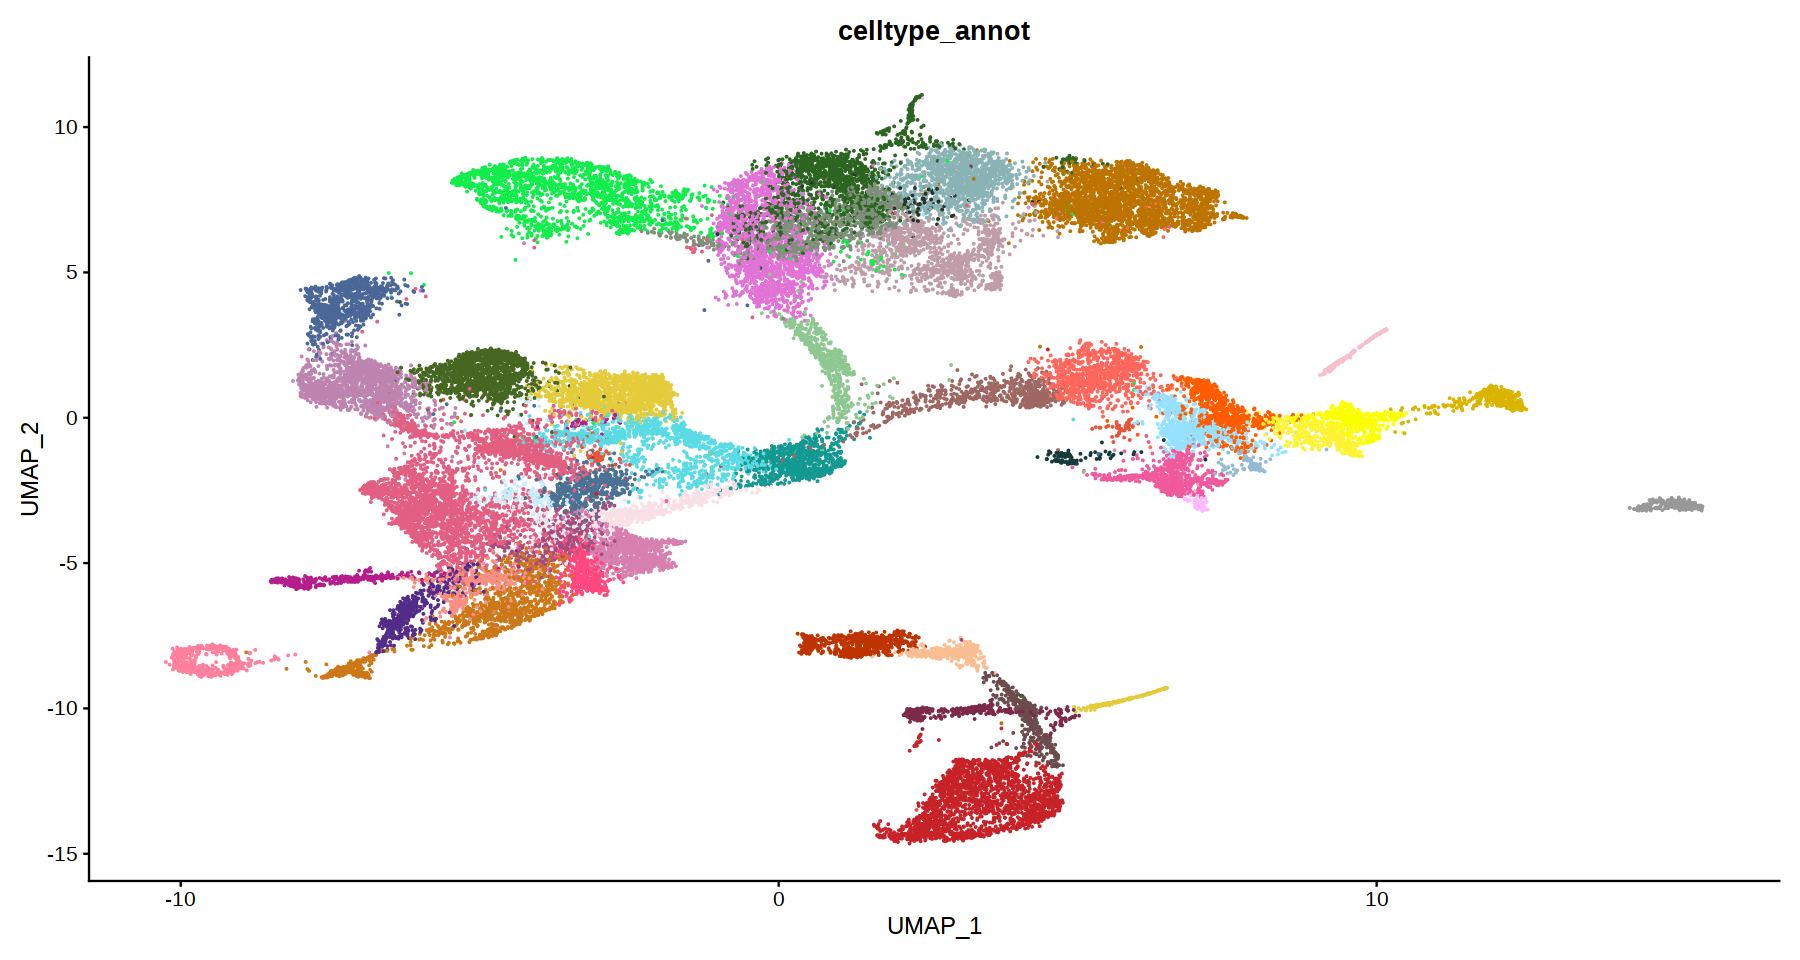

In [167]:
DimPlot(seurat, reduction = "umap", group.by='celltype_annot') + 
    scale_color_manual(values = opts$celltype.colors) + 
    theme(legend.position = 'none')

In [168]:
colnames(seurat@meta.data)

[1] "orig.ident"      "nCount_RNA"      "nFeature_RNA"    "RNA_snn_res.0.5"
 [5] "seurat_clusters" "RNA_snn_res.10"  "celltype"        "celltype_annot" 
 [9] "RNA_snn_res.15"  "RNA_snn_res.20"  "pass"            "RNA_snn_res.5"

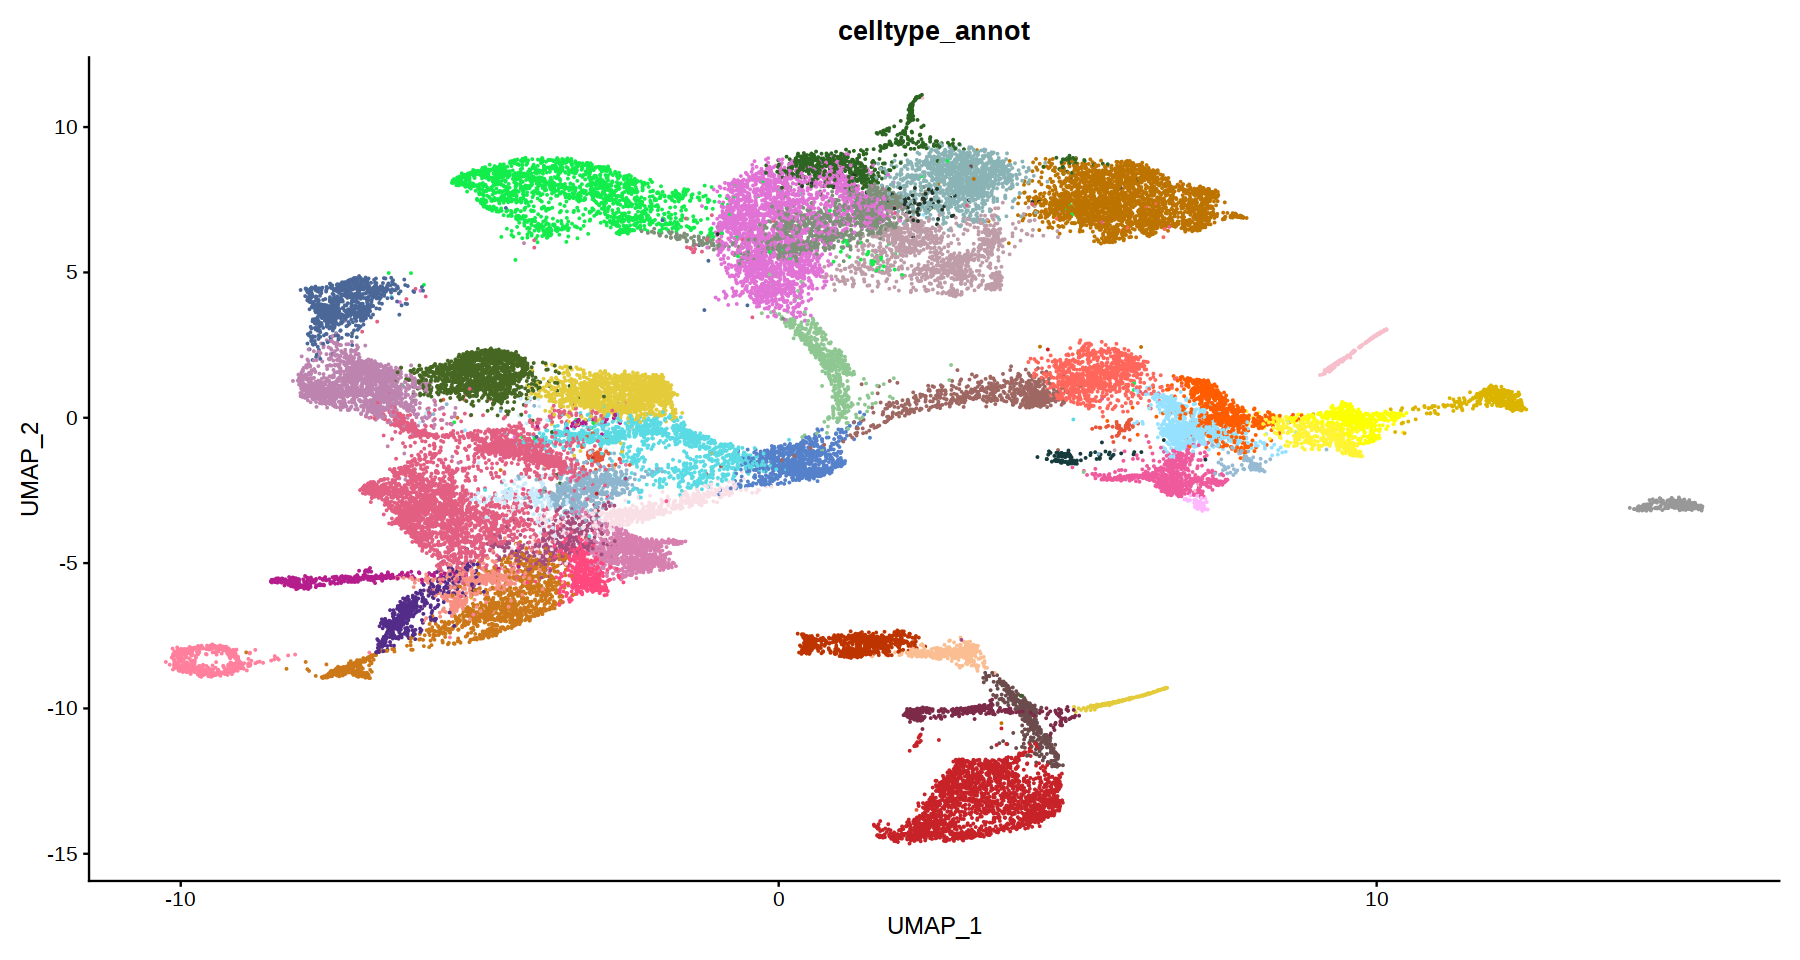

In [169]:
test = as.data.table(seurat@meta.data) %>%
    .[, tdTom := sample_metadata$tdTom] %>% 
    .[tdTom == FALSE] %>% 
    .[,clust_tot := .N, by='seurat_clusters'] %>%
    .[,celltype_clust := .N, by=c('celltype','seurat_clusters')] %>%
    unique(by=c('celltype','seurat_clusters')) %>%
    .[,proportion := round(celltype_clust/clust_tot*100, 2)] %>%
    .[order(-proportion)] %>% 
    unique(by='seurat_clusters') %>% 
   # .[,celltype_annot := ifelse(proportion > 35, celltype, 'unknown')] 
    .[,celltype_annot := celltype] 

seurat@meta.data$celltype_annot = test[match(seurat@meta.data$seurat_clusters, seurat_clusters),celltype_annot]

DimPlot(seurat, reduction = "umap", group.by='celltype_annot') + 
    scale_color_manual(values = opts$celltype.colors) + 
    theme(legend.position = 'none')

In [170]:
colnames(sample_metadata)

[1] "cell"                      "sample"                   
 [3] "barcode"                   "nFeature_RNA"             
 [5] "nCount_RNA"                "mitochondrial_percent_RNA"
 [7] "ribosomal_percent_RNA"     "stage"                    
 [9] "tdTom"                     "idx"                      
[11] "tdTom_corr"                "pass_rnaQC"               
[13] "doublet_score"             "doublet_call"             
[15] "celltype.mapped_mnn"       "celltype.score_mnn"       
[17] "stage.mapped_mnn"          "cellstage.score_mnn"      
[19] "closest.cell_mnn"

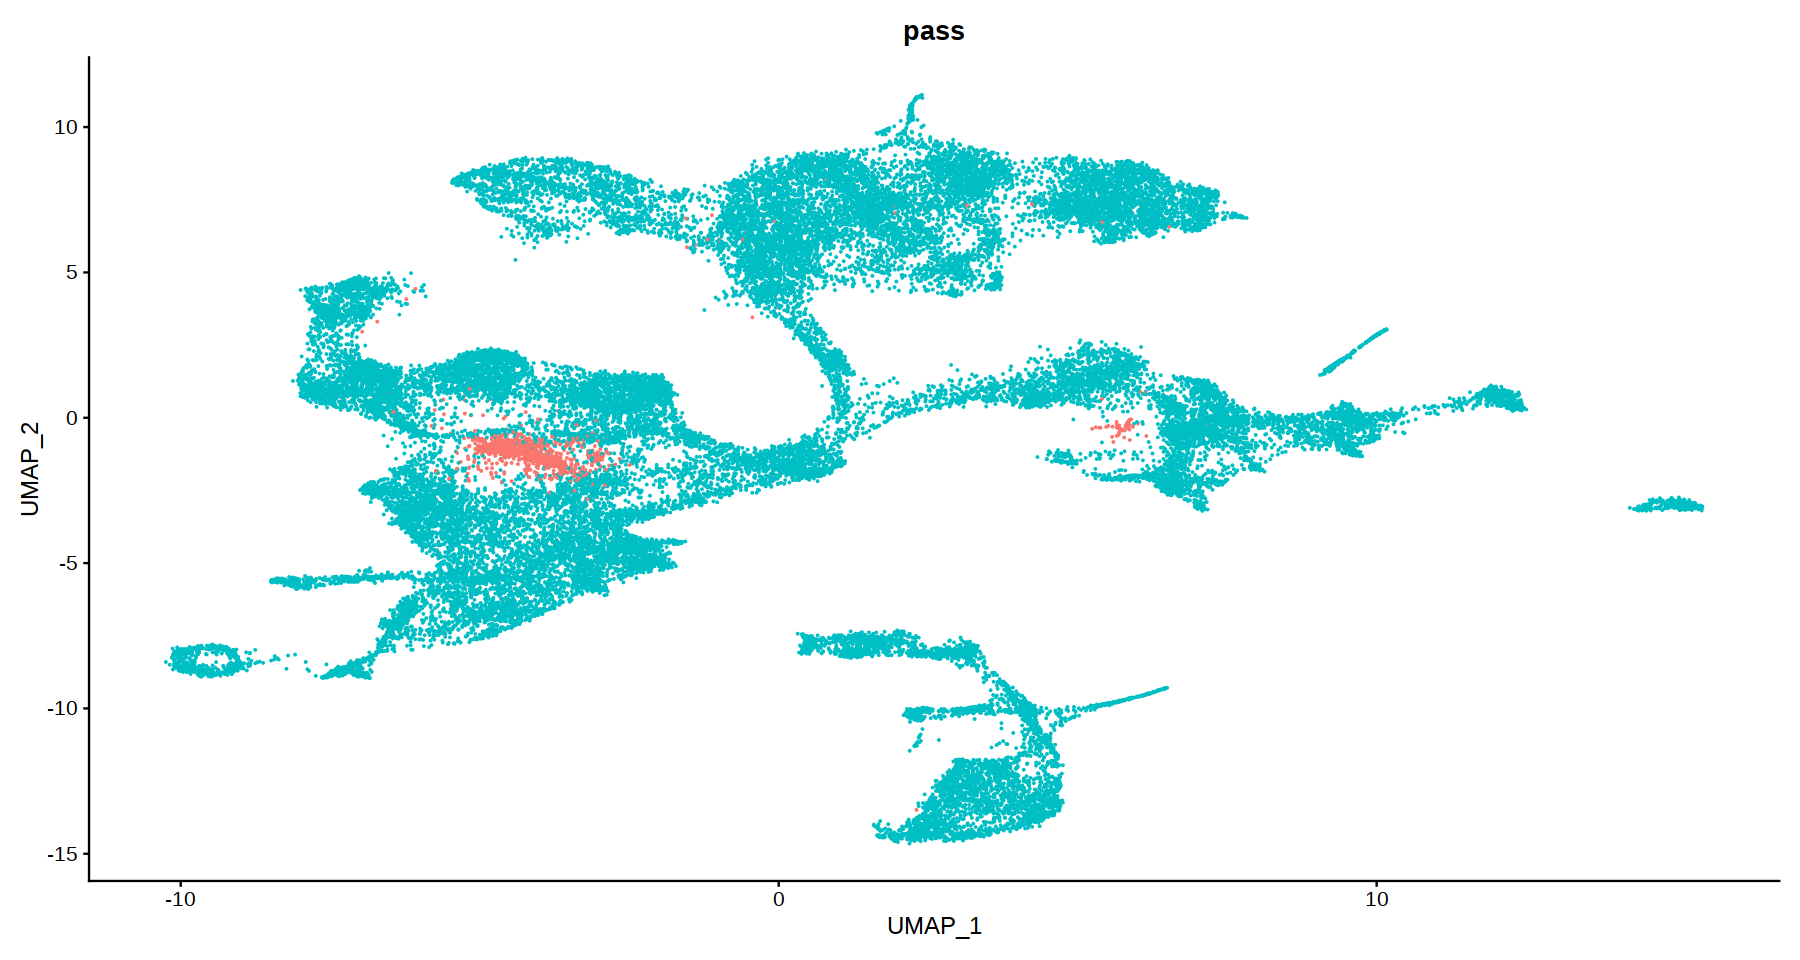

In [172]:
test = as.data.table(seurat@meta.data) %>%
    .[, score := as.numeric(sample_metadata$celltype.score_mnn)] %>% 
    .[,mean_mapping_score := mean(score), by='seurat_clusters'] %>%
    unique(by='seurat_clusters') %>% 
    .[,c('seurat_clusters', 'mean_mapping_score')] %>%
    .[, pass := ifelse(mean_mapping_score>0.5, TRUE, FALSE)]

seurat@meta.data$pass = test[match(seurat@meta.data$seurat_clusters, seurat_clusters),pass]

DimPlot(seurat, reduction = "umap", group.by='pass') + 
    theme(legend.position = 'none')

In [161]:
head(test)

seurat_clusters mean_mapping_score
1 2               0.9967201         
2 68              0.9565591         
3 77              0.7775494         
4 53              0.9939506         
5 125             0.9573770         
6 62              0.5951839

Warning message:
“Using `bins = 30` by default. Pick better value with the argument `bins`.”


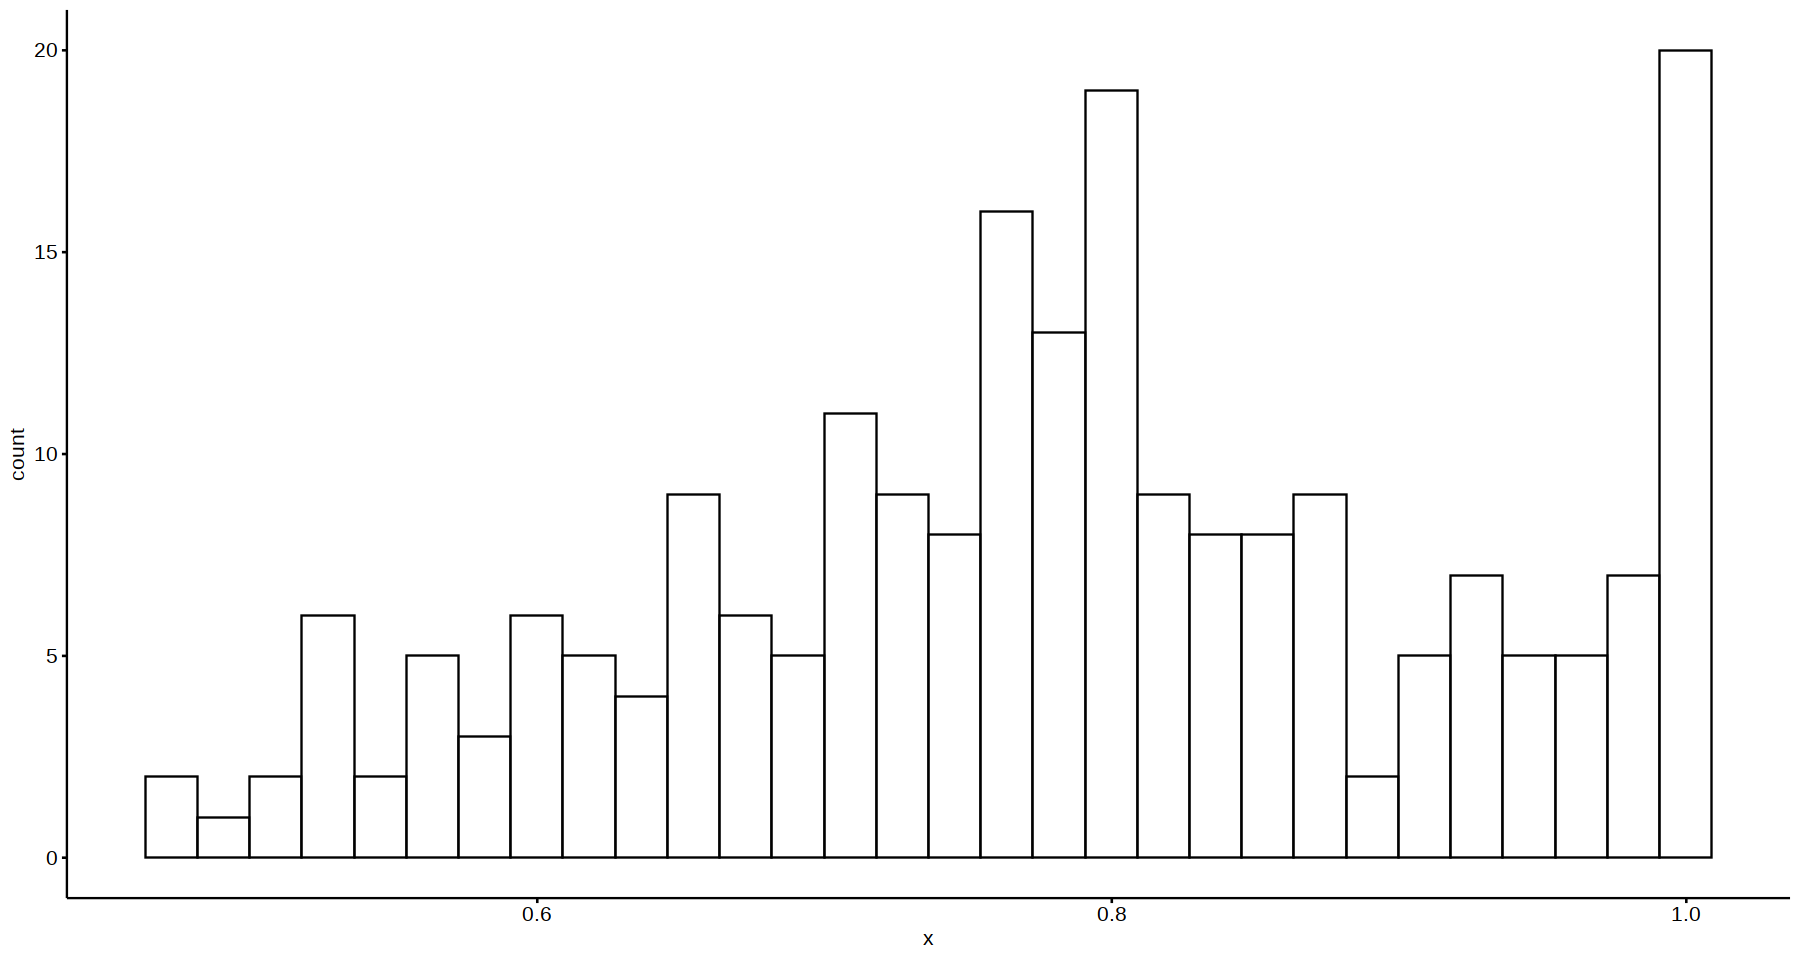

In [158]:
gghistogram(test$mean_mapping_score)

In [ ]:
options(repr.plot.width=15, repr.plot.height=8)
ggplot(as.data.frame(umap), aes(UMAP1, UMAP2, col=sample_metadata$celltype.score_mnn)) + 
    geom_point() + 
    viridis::scale_color_viridis(begin=1, end=0) + 
    theme_void()

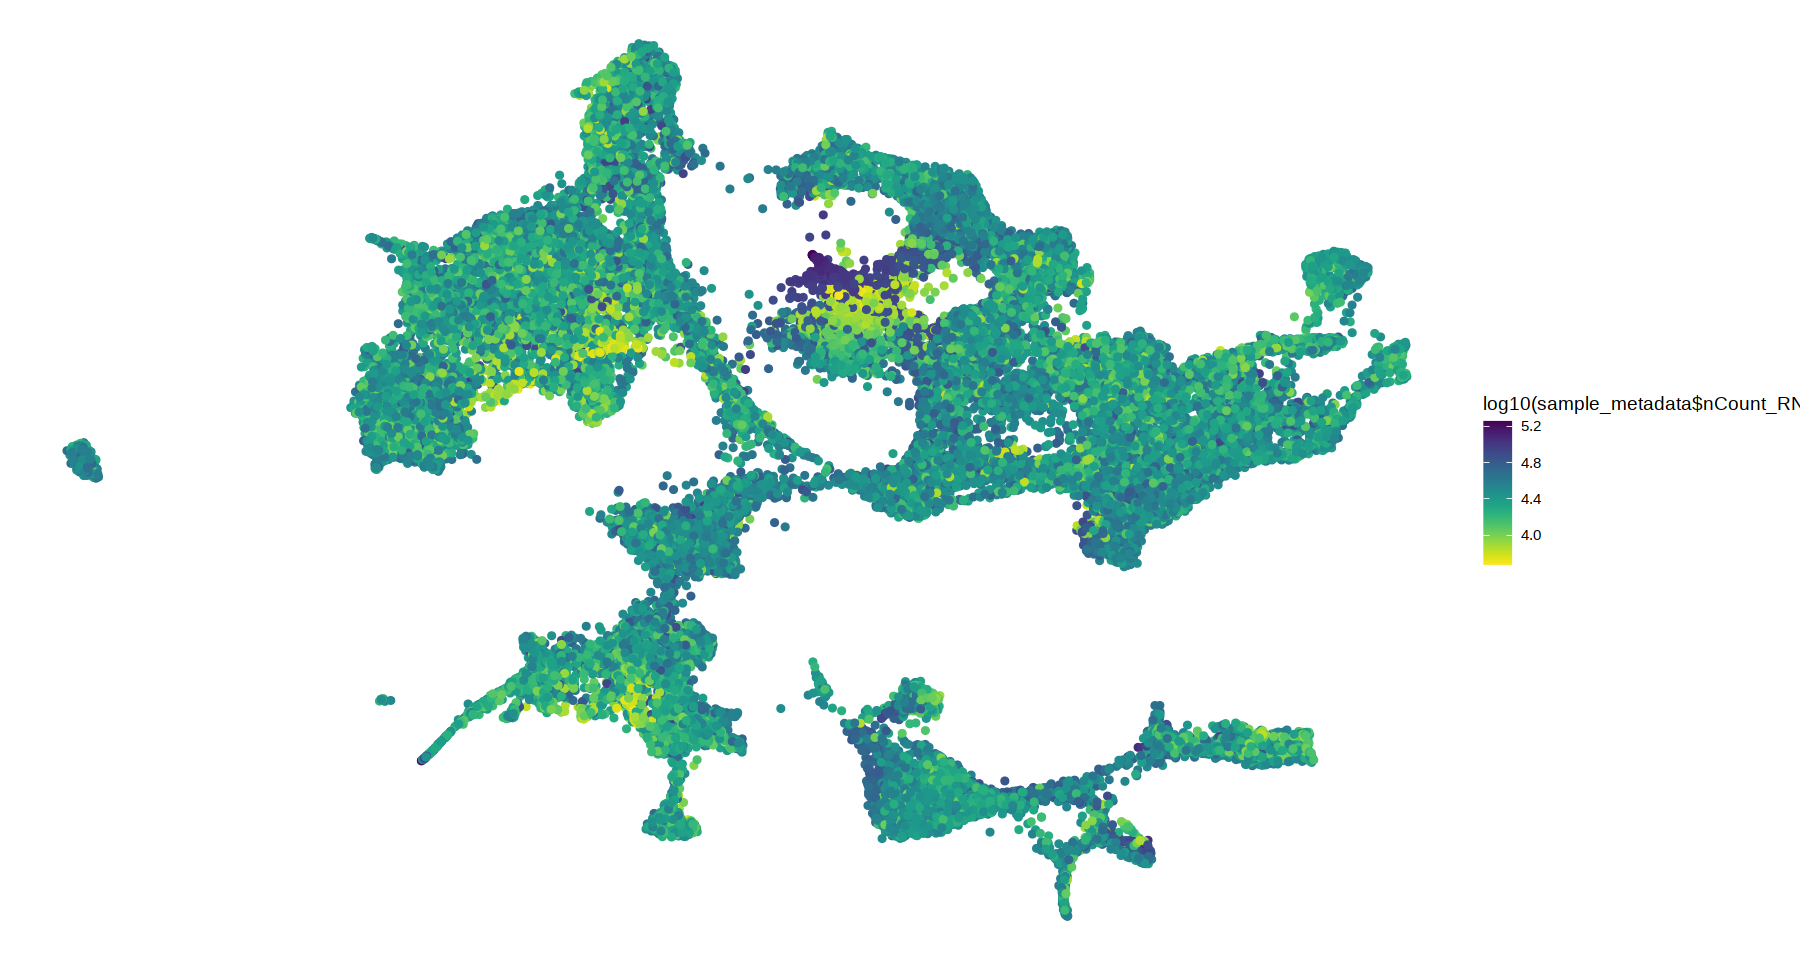

In [44]:
options(repr.plot.width=15, repr.plot.height=8)
ggplot(as.data.frame(umap), aes(UMAP1, UMAP2, col=log10(sample_metadata$nCount_RNA))) + 
    geom_point() + 
    viridis::scale_color_viridis(begin=1, end=0) + 
    theme_void()

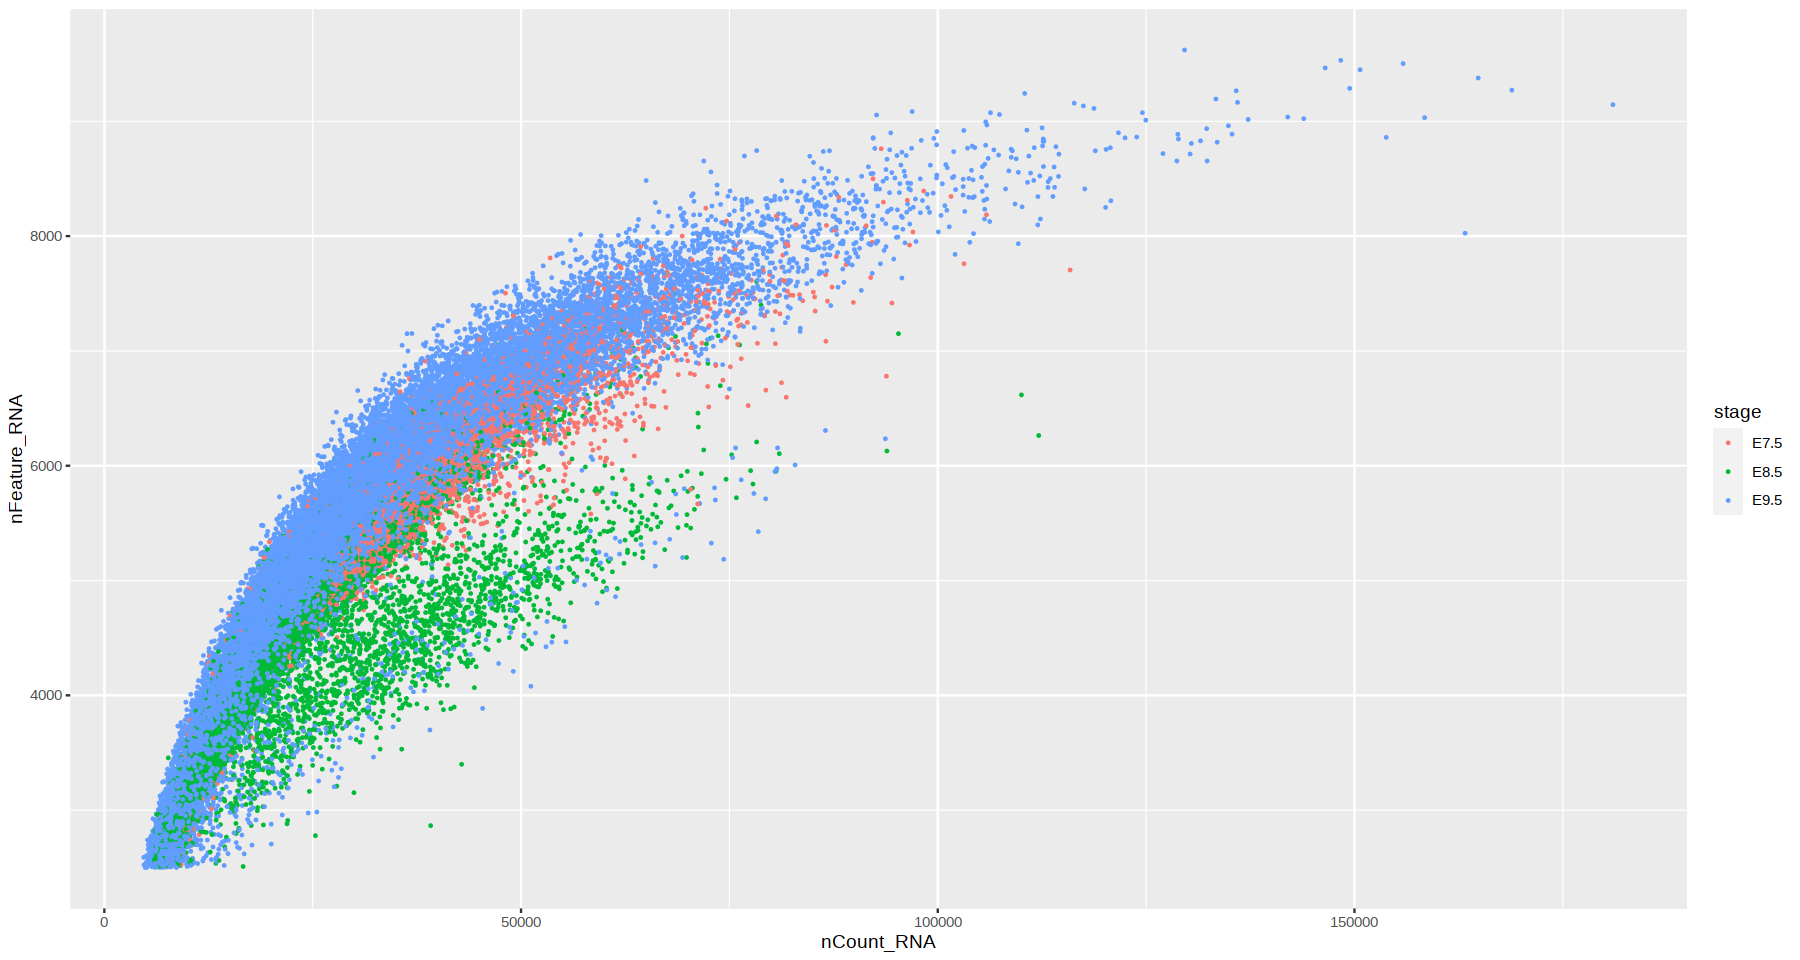

In [70]:
ggplot(sample_metadata, aes(nCount_RNA, nFeature_RNA, col=stage)) + geom_point(size=0.3)

In [66]:
nrow(sample_metadata[log10(nCount_RNA)<=4 | log10(nCount_RNA)>=5])

[1] 1737

In [56]:
log10(10000)

[1] 4

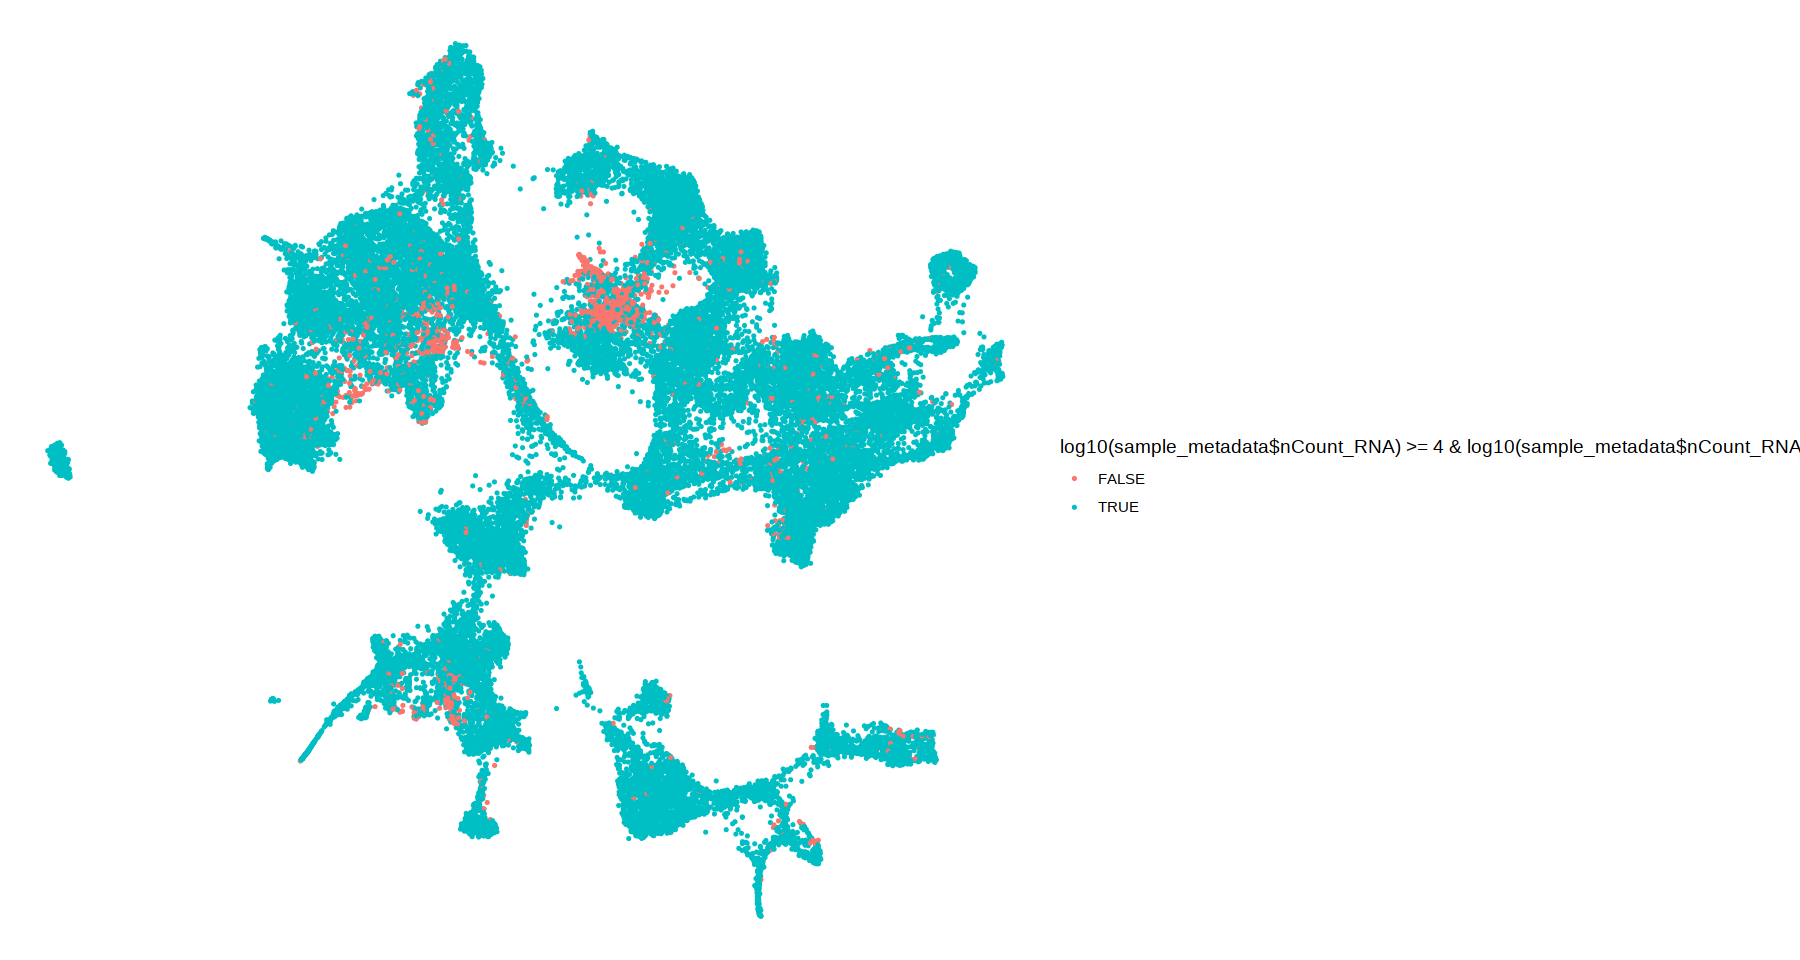

In [62]:
options(repr.plot.width=15, repr.plot.height=8)
ggplot(as.data.frame(umap), aes(UMAP1, UMAP2, col=log10(sample_metadata$nCount_RNA)>=4 & log10(sample_metadata$nCount_RNA)<=5  )) + 
    geom_point(size=0.4) + 
  #  viridis::scale_color_viridis(begin=1, end=0) + 
    theme_void()

Warning message:
“Using `bins = 30` by default. Pick better value with the argument `bins`.”


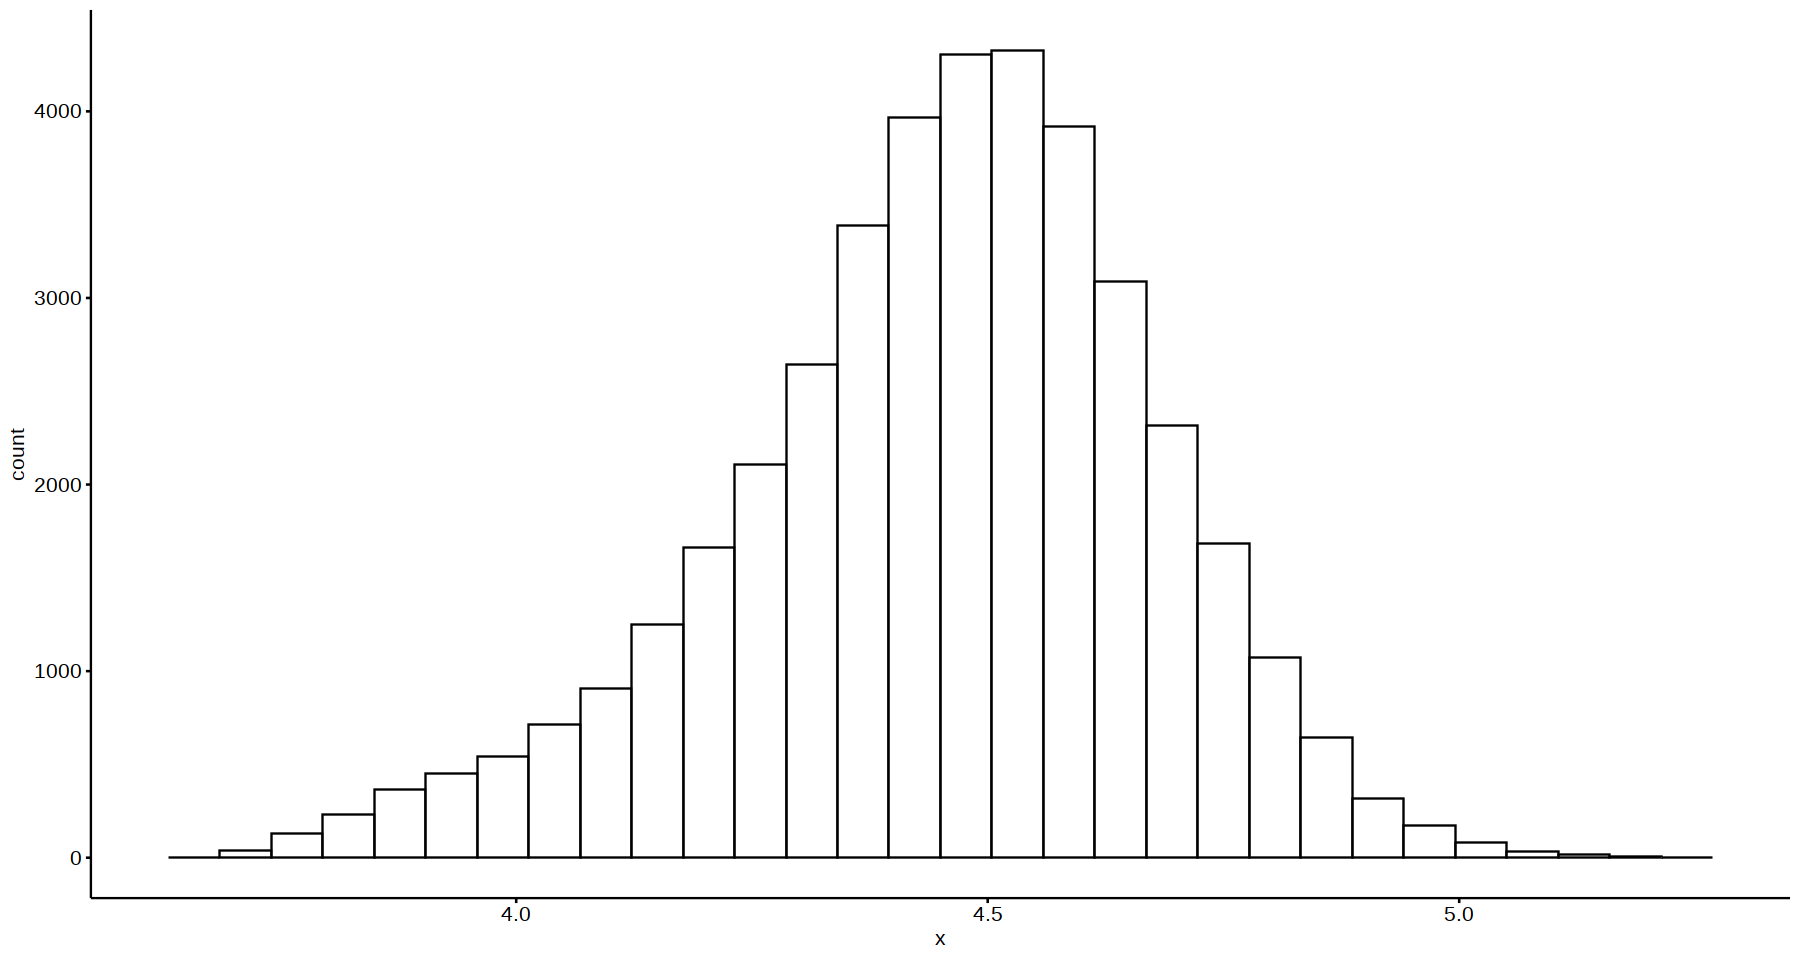

In [42]:
gghistogram(log10(sample_metadata$nCount_RNA))

In [49]:
quantile(log10(sample_metadata$nCount_RNA), 0.03)
quantile(log10(sample_metadata$nCount_RNA), 0.97)

3% 
3.958114

97% 
4.836202

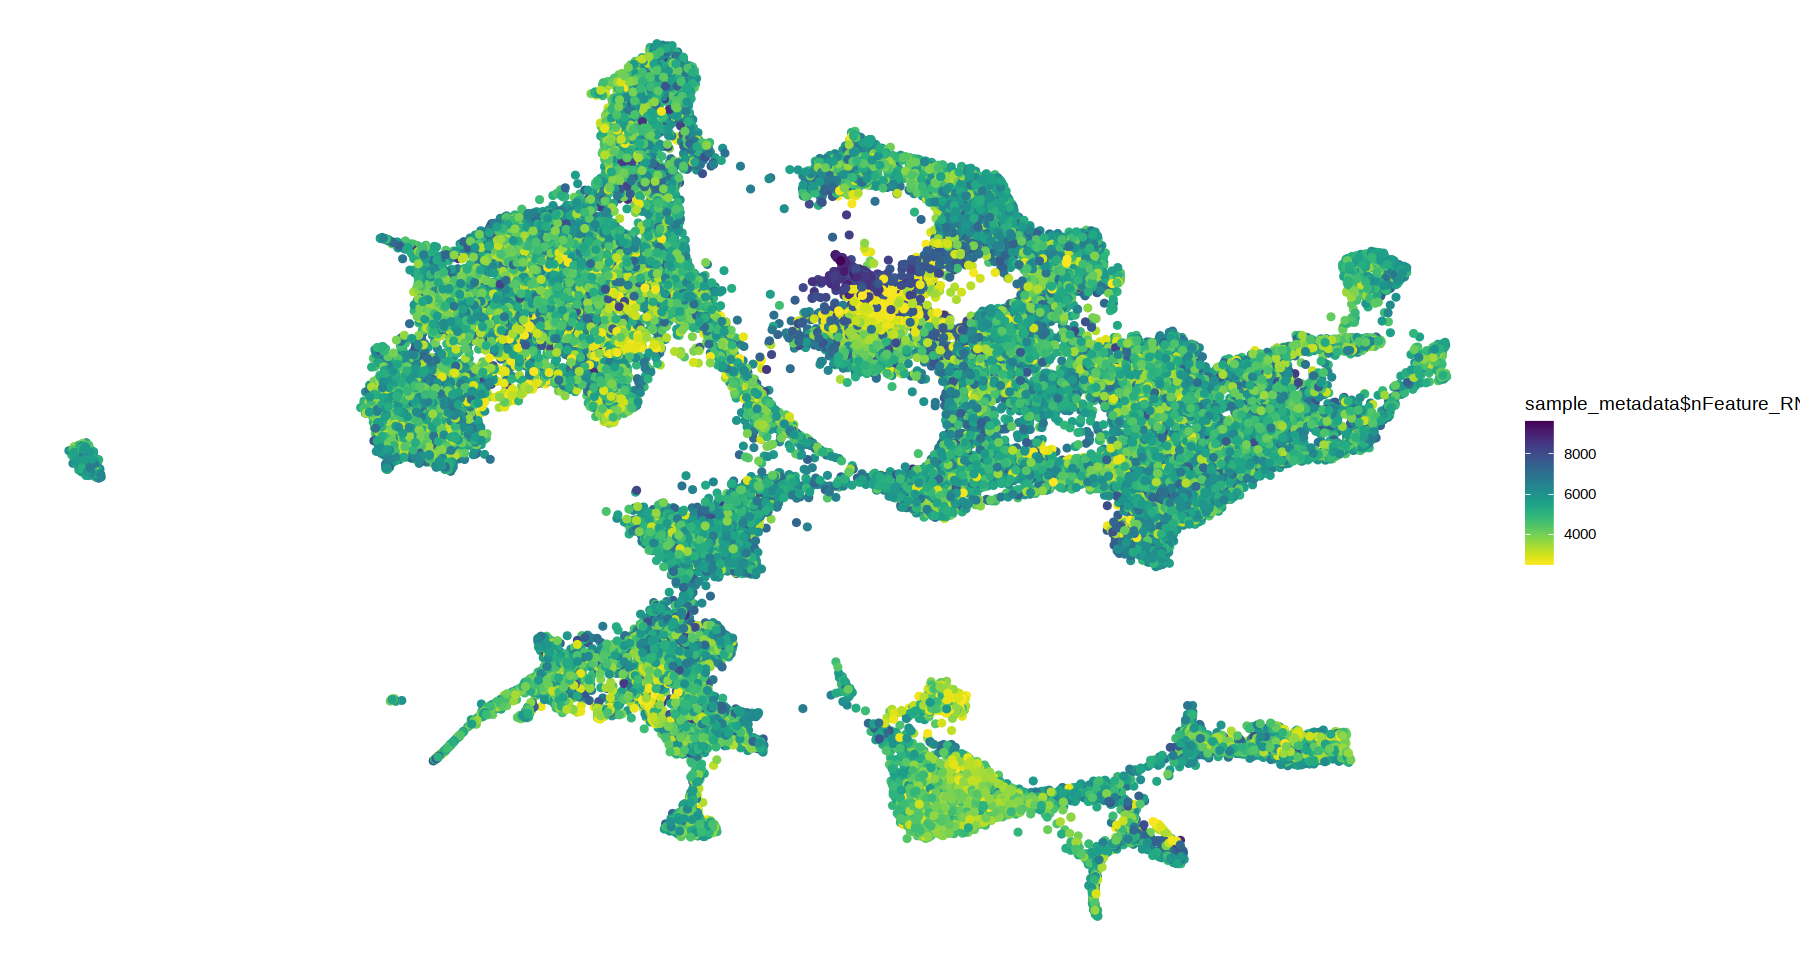

In [29]:
options(repr.plot.width=15, repr.plot.height=8)
ggplot(as.data.frame(umap), aes(UMAP1, UMAP2, col=sample_metadata$nFeature_RNA)) + 
    geom_point() + 
    viridis::scale_color_viridis(begin=1, end=0) + 
    theme_void()